In [33]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'microsoft-catsvsdogs-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F550917%2F1003830%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T131214Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50414009ae56e9957fe71e103ebda0ce5744e4c14f15375e6a9c5ff2437ec24857854fe567ef471f9a732d2870d3b811907119c11fd4a050564529f888cfacfb953d56cdbcf0d6bc9fc5952467d683bb2f6fa869394f29f684bb46afb94a7a3bedf00e57a392ce3f38382e6522680ac9d933168d3ca6f51e477571171f818758915c2b8e284a1531d0767b135e8edcf296f67325d9ec0d982e4713a1ec4cda56f558dbb519a7623fa5377ff77a20f65c16c63da51fcfb9882981444548818c31f974baa97723de7ea03065bf8a8accddbd36034fdce8f87b39e56467f232ba5b9f234d8db41e7ff3580c6d156744f4fdacf5e95a50d27d4b8a515b169b41c3f2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 825979578 bytes downloaded
Downloaded and uncompressed: microsoft-catsvsdogs-dataset
Data source import complete.


**Imports**

In [34]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Checking the Data Split**

In [35]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [36]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

Error failed to make directory


In [37]:
#Define data path
CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

**Create folders for training, testing and validation**

In [38]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11250
11250
625
625
625
625


**Split the data and save it into the created folders**

In [39]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [40]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


**Printing the number of images present in each folder**

In [41]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

12391
12385
1218
1218
1221
1219


In [42]:
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen =  ImageDataGenerator(rescale=1./255.)
if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(rescale=1./255.)

In [43]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 24774 images belonging to 2 classes.
Found 2436 images belonging to 2 classes.
Found 2436 images belonging to 2 classes.


In [44]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

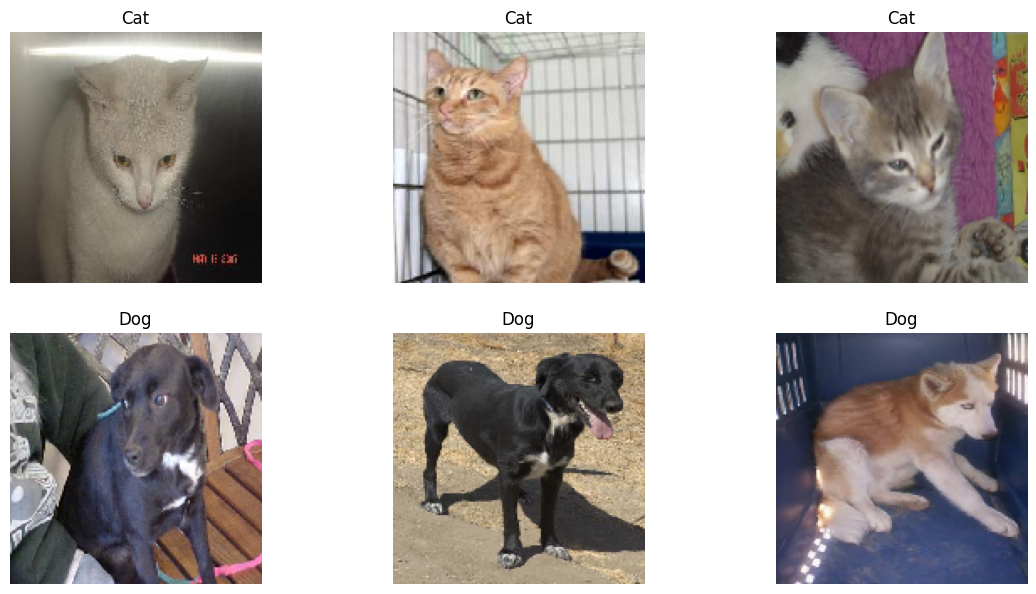

In [45]:
plot_data(train_generator,7)

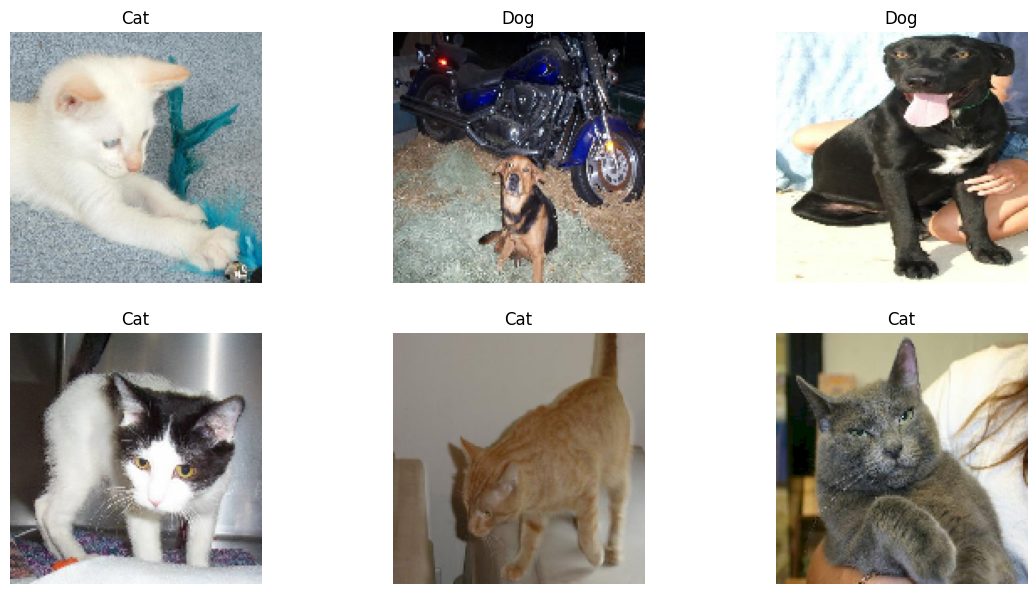

In [46]:
plot_data(validation_generator,7)

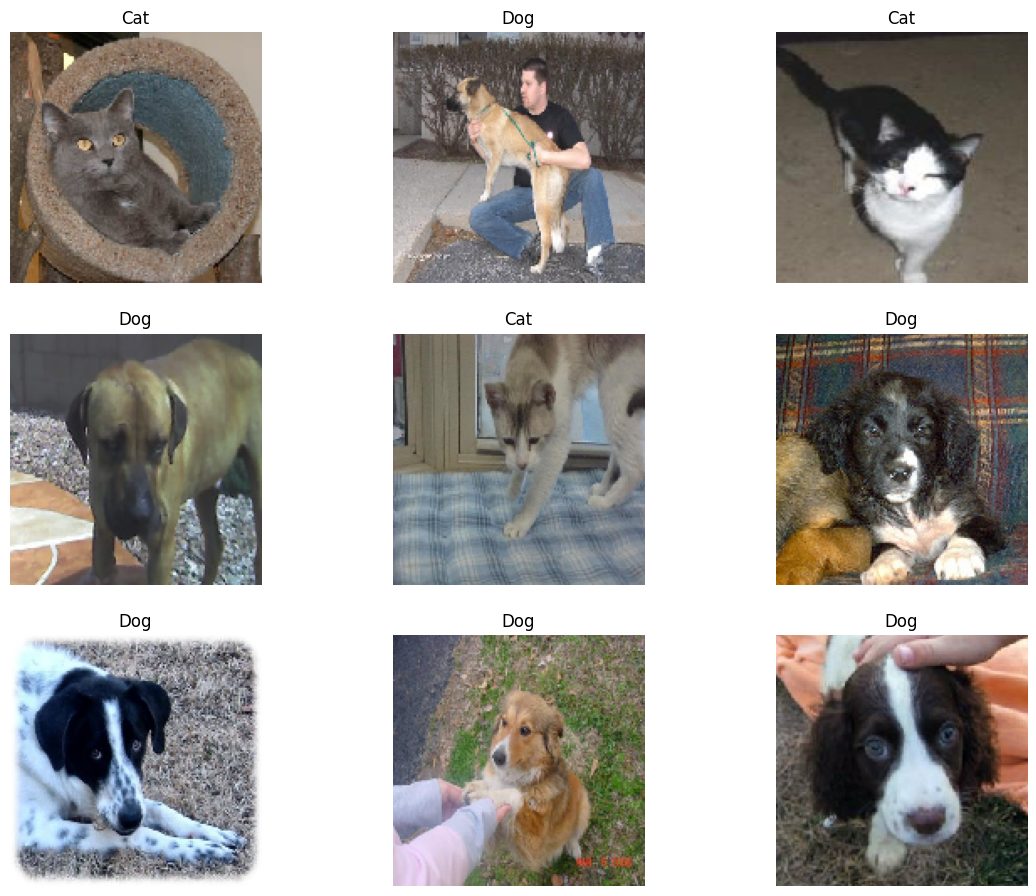

In [47]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

**Defining the model**

In [48]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [49]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

**Training the model**

In [18]:
r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10
251/352 [====================>.........] - ETA: 16s - loss: 0.6966 - accuracy: 0.5302

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



352/352 [==============================] - 70s 166ms/step - loss: 0.6906 - accuracy: 0.5451 - val_loss: 0.6482 - val_accuracy: 0.6296
Epoch 2/10
352/352 [==============================] - 53s 150ms/step - loss: 0.6446 - accuracy: 0.6283 - val_loss: 0.6022 - val_accuracy: 0.6640
Epoch 3/10
352/352 [==============================] - 53s 150ms/step - loss: 0.6058 - accuracy: 0.6762 - val_loss: 0.5577 - val_accuracy: 0.7280
Epoch 4/10
352/352 [==============================] - 56s 158ms/step - loss: 0.5863 - accuracy: 0.6977 - val_loss: 0.5378 - val_accuracy: 0.7448
Epoch 5/10
352/352 [==============================] - 53s 149ms/step - loss: 0.5610 - accuracy: 0.7154 - val_loss: 0.5276 - val_accuracy: 0.7208
Epoch 6/10
352/352 [==============================] - 53s 149ms/step - loss: 0.5403 - accuracy: 0.7320 - val_loss: 0.5279 - val_accuracy: 0.7352
Epoch 7/10
352/352 [==============================] - 52s 148ms/step - loss: 0.5257 - accuracy: 0.7414 - val_loss: 0.4780 - val_accuracy: 0.7

In [19]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

20/20 [==============================] - 2s 118ms/step - loss: 0.4155 - accuracy: 0.8168


**Plotting the images and prediction labels from the generator**

In [20]:
def plot_prediction(generator, n_images):
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

2/2 [==============================] - 1s 9ms/step


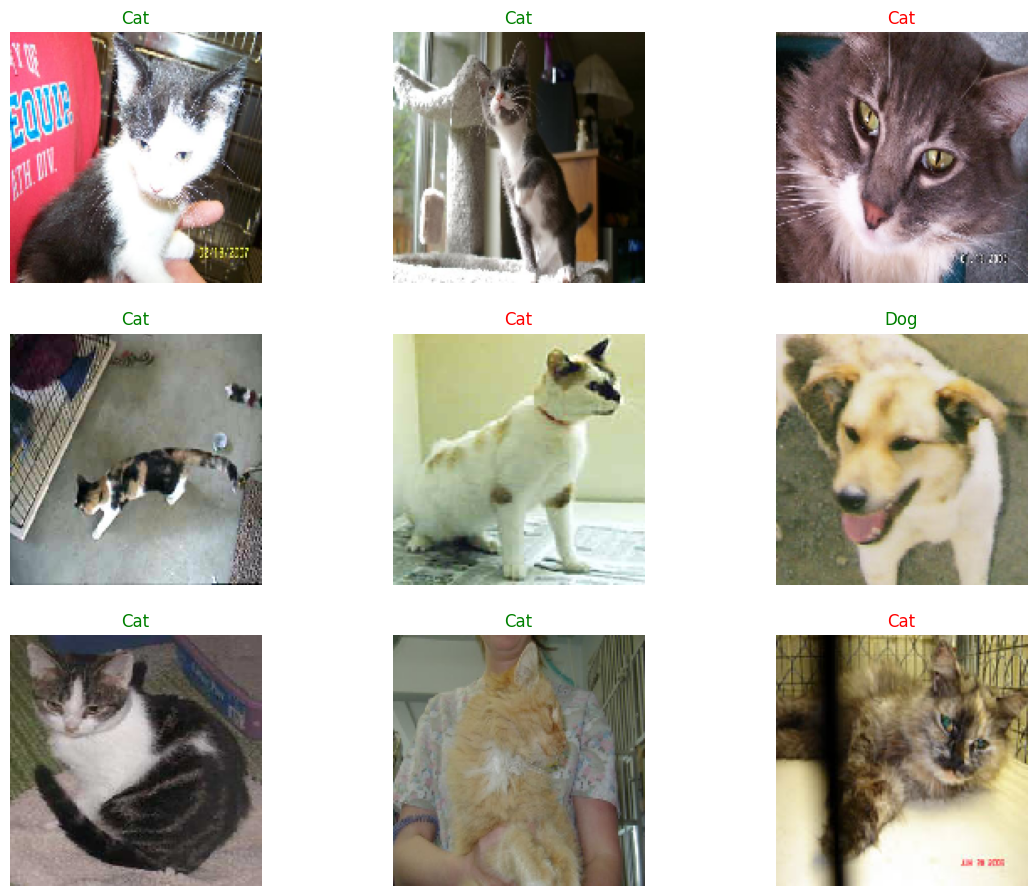

In [21]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 [==============================] - 0s 19ms/step


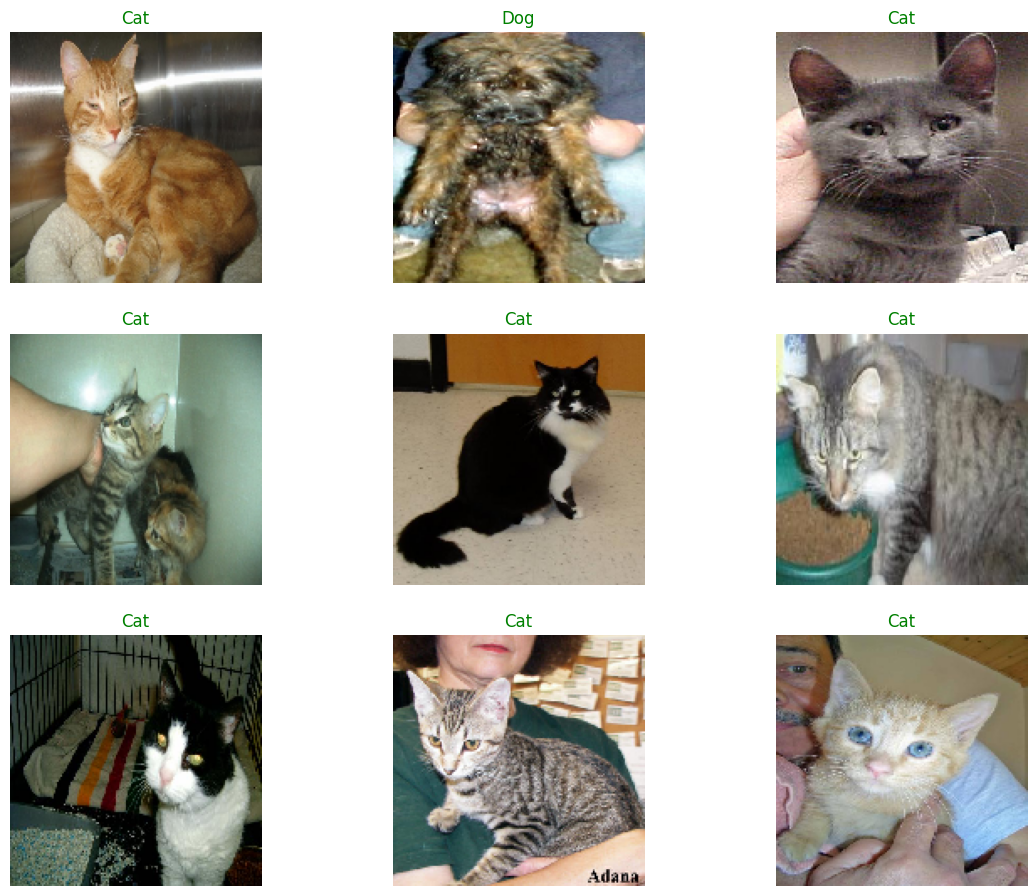

In [22]:
plot_prediction(validation_generator, 10)

In [23]:
# Create a model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [24]:
# Use the model to make predictions on the test generator
images, _ = test_generator.next()
features, results = activation_model.predict(images)

2/2 [==============================] - 0s 9ms/step


**Displays the image with predicted output, feature selected and probability**

In [25]:
def show_cam(image_index, features, results):
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image
    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [26]:
def show_maps(desired_class, num_maps):

    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

Predicted Class = Dog, Probability = 0.87099963


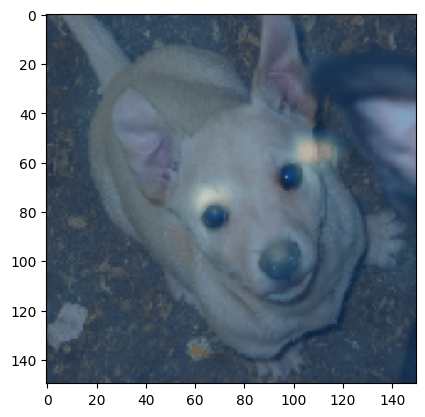

Predicted Class = Dog, Probability = 0.5968708


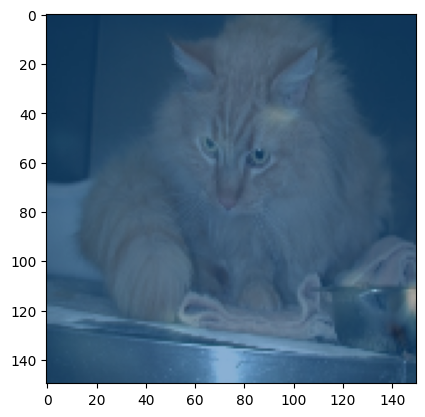

Predicted Class = Dog, Probability = 0.8599934


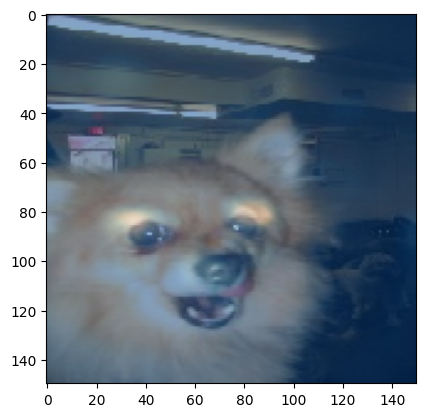

Predicted Class = Dog, Probability = 0.757957


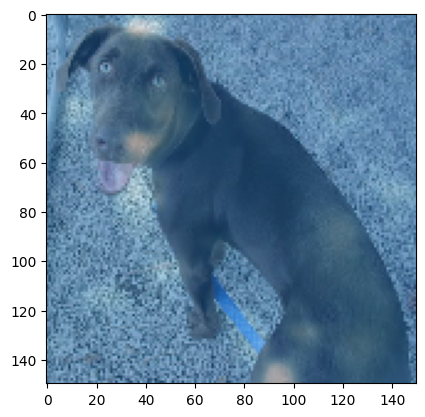

Predicted Class = Dog, Probability = 0.5909162


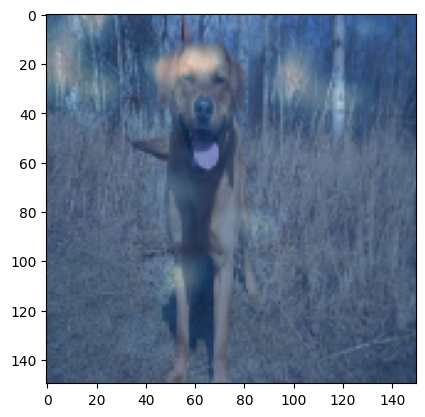

In [27]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.7374718


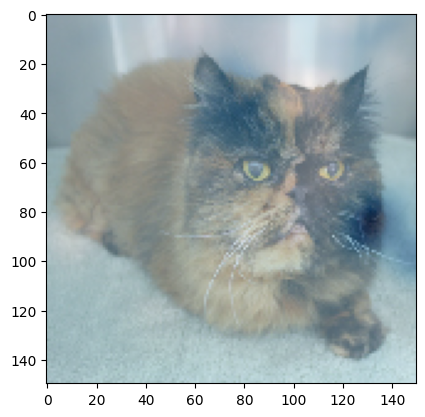

Predicted Class = Cat, Probability = 0.7792939


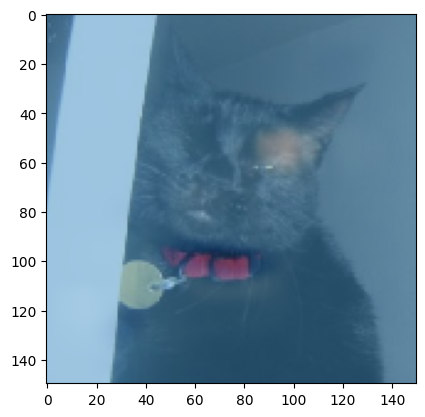

Predicted Class = Cat, Probability = 0.9258563


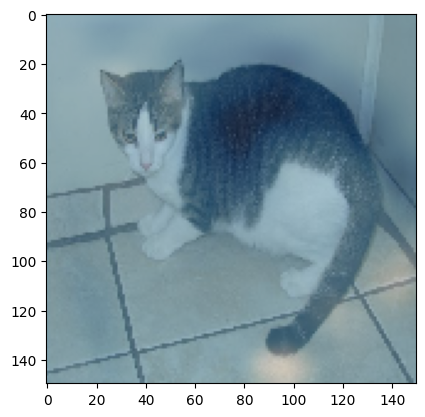

Predicted Class = Cat, Probability = 0.54968977


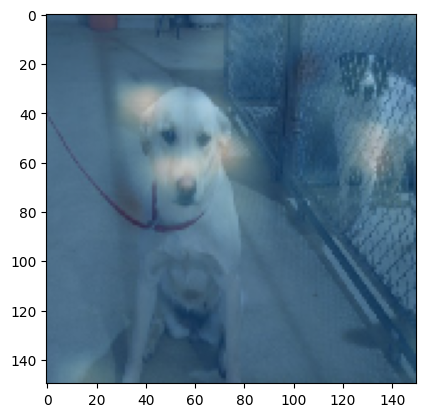

Predicted Class = Cat, Probability = 0.6124921


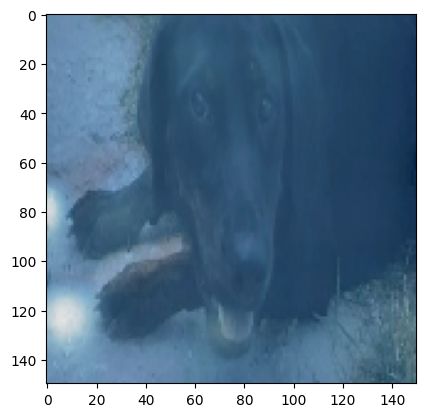

In [28]:
show_maps(desired_class=0, num_maps=5)

In [29]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.540345  0.731976  0.527929        0.7352
6  0.525674  0.741399  0.477966        0.7704
7  0.509163  0.756112  0.467976        0.7728
8  0.484370  0.771580  0.431413        0.8032
9  0.460574  0.785981  0.415469        0.8168

**Accuracy Plot**

In [30]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

**Loss Plot**

In [31]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [32]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.540345  0.731976  0.527929        0.7352
6  0.525674  0.741399  0.477966        0.7704
7  0.509163  0.756112  0.467976        0.7728
8  0.484370  0.771580  0.431413        0.8032
9  0.460574  0.785981  0.415469        0.8168